## COMP 341: Practical Machine Learning
## Homework Assignment 5: Who Said It?
### Due: Thursday, November 3 at 11:59pm on Gradescope

In this assignment, we will explore how machine learning can be used to explore text documents. Towards this end, we have assembled collections of text from different speakers. When possible, this text was derived from unique talks, papers, or books. Text passages are categorized based on the characteristics of the author / speaker (e.g., an actor, writer, academic, etc).

We handled the initial text preprocessing (including lemmatization which helps reduce words to a singular representative form) to provide you with two clean matrices - a word counts per document (bag_of_words) and normalized word counts in the form of tf-idf (you can read more about tf-idf [here](https://en.wikipedia.org/wiki/Tf–idf)).

The speaker / category labels are provided in (`document_labels.txt`), which correspond to the rows in the matrices. Exploring these data, we will attempt three tasks - identifying topics and potential authors for the "other" category, as well as explore more in-depth classification tasks predicting the category of a passage of text.

As always, fill in missing code following `# TODO:` comments or `####### YOUR CODE HERE ########` blocks and be sure to answer the short answer questions marked with `[WRITE YOUR ANSWER HERE]` in the text.

All code in this notebook will be run sequentially so make sure things work in order! Be sure to also use good coding practices (e.g., logical variable names, comments as needed, etc), and make plots that are clear and legible.

For this assignment, there will be **15 points** allocated for general coding points:
* **10 points** for coding style
* **5 points** for code flow (accurate results when everything is run sequentially)

### Setup
First, we need to import some libraries that are necessary to complete the assignment.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Add additional modules/libraries to import here (rather than wherever you first use them below):

In [ ]:
# additional modules/libraries to import
from plotnine import *
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

We provide some code to get the data file for this assignment into your workspace below. You only need to do the following 4 steps once:
1. Go to 'My Drive' in your own Google Drive
2. Make a new folder named `comp341`
3. From the [Google Drive link](https://drive.google.com/drive/folders/1OhyG5-wszm6NsMTYdyVxXaq0xQctBKlf), you can right click the `comp341-hw5` title, and select `Add shortcut to Drive`, and add a link to the whole folder to your `comp341` folder. This is a convenient alternative to having to download and re-upload the files to your own drive.

If you run into trouble with accessing the files from the shortcut, then:
4. Download the following files: `bag_of_words.csv`, `tfidf.csv`, `document_labels.csv`, `test-bag_of_words.csv`, `test-tfidf.csv` to your computer.
5. In the `comp341` folder you created in step 2, click `New -> File Upload` and upload the downloaded files from your computer.

Now, we will mount your local Google Drive in colab so that you can read the file in (you will need to do this each time your runtime restarts).

In [ ]:
# note that this command will trigger a request from google to allow colab
# to access your files: you will need to accept the terms in order to access
# the files this way
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# if you followed the instructions above exactly, each file should be
# in comp341/; if your files are in a different directory
# on your Google Drive, you will need to change the path below accordingly
DATADIR = '/content/drive/My Drive/comp341/hw5'

Mounted at /content/drive


In [ ]:
bag_of_words = pd.read_csv(DATADIR + '/bag_of_words.csv')
doc_labels = pd.read_csv(DATADIR + '/document_labels.csv')
tfidf = pd.read_csv(DATADIR + '/tfidf.csv')

In [ ]:
bag_of_words

,textid,0,000,1,10,11,12,13,14,15,...,written,wrong,wrote,x,yeah,year,yes,yet,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,733,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
556,734,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
557,737,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558,739,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
doc_labels

,textid,category,person
0,0,president,10.0
1,1,president,4.0
2,2,academic,14.0
3,3,academic,6.0
4,4,actor,2.0
...,...,...,...
555,733,academic,5.0
556,734,academic,14.0
557,737,president,4.0
558,739,academic,13.0


In [ ]:
tfidf

,textid,0,000,1,10,11,12,13,14,15,...,written,wrong,wrote,x,yeah,year,yes,yet,york,young
0,0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
1,1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.068940,0.00000,0.0,0.0,0.0
3,3,0.208129,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.18867,0.0,0.0,0.0
4,4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,733,0.130634,0.0,0.102967,0.0,0.0,0.0,0.0,0.0,0.0,...,0.128157,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
556,734,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
557,737,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
558,739,0.123106,0.0,0.097033,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0


### Part 1: Data Exploration
In this section we will explore our data using unsupervised learning to infer general topics, as well as try to infer the number of unique authors/speakers in the 'other' category.

In [ ]:
# TODO: how many categories are there in this dataset? What about authors?
print(len(doc_labels.category.unique())) # category
print(len(doc_labels.person.unique())) # authors

4
13


In [ ]:
# TODO: using the bag_of_words, run Latent Dirichlet Allocation to find 10 topics.
# List the top 10-15 words that characterize each of these topics.

drop_textid = bag_of_words.drop(columns='textid')

# run LDA on bag_of_words after dropping textid
lda = LatentDirichletAllocation(n_components=10)
x_topics = lda.fit_transform(drop_textid)
x_topics = pd.DataFrame(lda.components_).transpose() # transpose
x_topics.columns = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']

# add words column
words = pd.DataFrame(drop_textid.columns, columns=['word'])
x_topics = pd.concat([words, x_topics], axis=1)

# get top 10 words for each topic
topics = x_topics.drop(columns='word').columns
top_words = []
for topic in topics:
  top_words.append(x_topics.nlargest(10, [topic]).word.values)

top_words

[array(['patient', 'study', 'p', 'value', 'one', 'test', 'jungreis',
        'kellis', 'icu', 'treatment'], dtype=object),
 array(['know', 'would', 'like', 'think', 'say', 'one', 'go', 'going',
        'thing', 'way'], dtype=object),
 array(['new', 'upon', 'u', 'machine', 'public', 'first', 'disease',
        'would', 'world', 'great'], dtype=object),
 array(['student', 'general', 'case', 'report', 'research', 'science',
        'percent', 'program', 'university', 'word'], dtype=object),
 array(['state', 'united', 'government', 'power', 'may', 'day', 'shall',
        'citizen', 'key', 'public'], dtype=object),
 array(['school', 'girl', 'world', 'child', 'education', 'year', 'thank',
        'woman', 'like', 'u'], dtype=object),
 array(['nation', 'united', 'state', 'american', 'world', 'country',
        'time', 'year', 'men', 'u'], dtype=object),
 array(['time', 'god', 'back', 'death', 'levitt', 'see', 'covid', 'would',
        'way', '19'], dtype=object),
 array(['american', 'people',

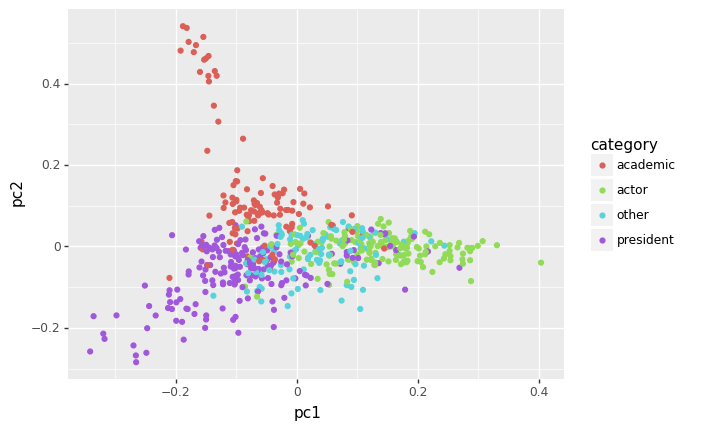

<ggplot: (8786020041117)>

In [ ]:
# TODO: use either PCA or t-SNE to reduce the data (either bag_of_words or tfidf)
# down to 2 dimensions, then visualize the documents (i.e., each point is a document),
# colored by their category

drop_textid = tfidf.drop(columns='textid')
pca = PCA(n_components=2)
x2d = pca.fit_transform(drop_textid)
x2d_df = pd.DataFrame(x2d, columns=['pc1', 'pc2'])
x2d_df = pd.concat([x2d_df, doc_labels.category], axis=1)

(ggplot(x2d_df, aes(x='pc1', y='pc2', color='category'))
+ geom_point())

**Short Answer Question**: Given the topics you identified with LDA and the dimensionality reduction plot above, do you think that there is enough information in our data (specifically, the bag of words) for the classification task of predicting the category for a passage of text? Explain.

`[WRITE YOUR ANSWER HERE]`

No. We still need to know which topics out of the ones identified with LDA corresponds with which category. However, it is good news that the dimensionality reduction plot and topics identified with LDA does show that there is good separation between each category, which would mean that it is possible to classify unknown texts.

The `other` category of documents consists of text passages from several types of distinct individuals that did not fit any into any of the other categories of documents. Since each individual is distinct we may be able to find clustered observations in the normalized bag of words (tf-idf).

In [ ]:
# TODO: Using tf-idf, take only data from the `other` category and reduce the number of dimensions to 2 with PCA

other = doc_labels.loc[doc_labels.category == 'other'].drop(columns=['category', 'person'])
other_df = pd.merge(other, tfidf, how="left", on=['textid'])
drop_textid = other_df.drop(columns='textid')

pca = PCA(n_components=2)
x2d = pca.fit_transform(drop_textid)
x2d_df = pd.DataFrame(x2d, columns=['pc1', 'pc2'])
x2d_df

,pc1,pc2
0,0.258282,0.099108
1,-0.003231,0.098245
2,-0.124191,0.178498
3,0.337248,0.052563
4,-0.005778,-0.248211
...,...,...
100,-0.274497,-0.382762
101,0.251938,-0.023997
102,-0.018117,-0.160326
103,0.059407,-0.060009


In [ ]:
# TODO: Cluster the resulting 2 dimensions from PCA above using k-means with k from 2-10 clusters, and
# store any values you will need to make an elbow plot and average silhouette score plot (below)

k_vals = []
silhouette = []
inertia = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters=k)
  y_pred = kmeans.fit_predict(x2d_df)

  k_vals.append(k)
  silhouette.append(silhouette_score(x2d_df, kmeans.labels_))
  inertia.append(kmeans.inertia_)

plots = pd.DataFrame({'k':k_vals, 'silhouette_score':silhouette, 'inertia':inertia})
plots

,k,silhouette_score,inertia
0,2,0.405414,4.021380
1,3,0.431777,2.090093
2,4,0.394188,1.479431
3,5,0.396983,1.137078
4,6,0.376651,0.912230
5,7,0.356042,0.800776
6,8,0.352106,0.703522
7,9,0.348404,0.612157
8,10,0.363736,0.536488


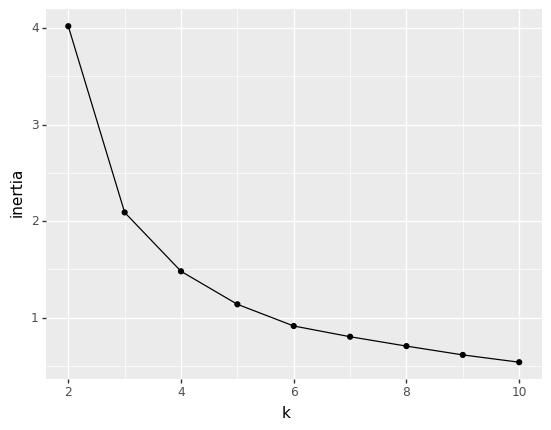

<ggplot: (8786019917361)>

In [ ]:
# TODO: make an elbow plot for k=2 to 10

(ggplot(plots, aes(x='k', y='inertia'))
+ geom_line()
+ geom_point())

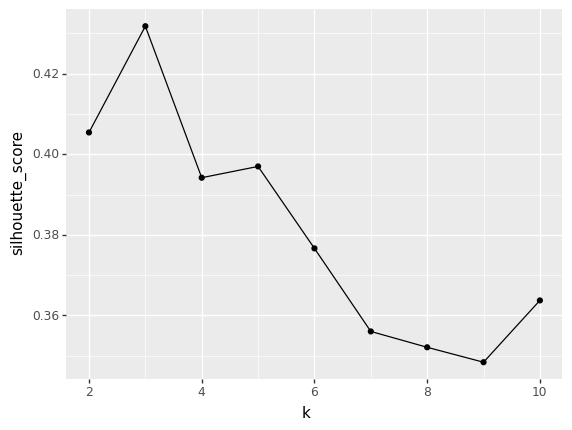

<ggplot: (8786015025413)>

In [ ]:
# TODO: make a plot of the average silhouette scores for k=2 to 10

(ggplot(plots, aes(x='k', y='silhouette_score'))
+ geom_line()
+ geom_point())

**Short Answer Question**: Using the elbow plot and the silhouette plots above, how many authors/speakers do you think there are for the `other` category of documents? (We are assuming that the number of clusters corresponds to the number of unique authors/speakers). Explain your choice.

`[WRITE YOUR ANSWER HERE]`

From the elbow and silhouette plots, it looks like there could be 3 authors/speakers from the 'other' category. This is because k=3 has the highest silhouette score and k=3 is where the performance stops increasing in the elbow plot (where the slope decreases).

### Part 2: Text Classification
In Part 1, we examined how the documents fall into several categories. Can we make a multiclass classifier that labels a passage of text with one of these categories?

As mentioned in class, you will have more freedom to use a classification algorithm of your choice. For the sections below, you can choose your favorite classification method and evaluate its performance by looking at ROC curves, precision-recall curves, and a confusion matrix.

In [ ]:
# TODO: Using any of the classification methods we have discussed in class, make a multiclass
# classifier to predict category label given tf-idf

x = tfidf.drop(columns='textid')
y = doc_labels.drop(columns=['textid', 'person'])

# split the training and testing data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6)
y_train = y_train.category
y_test = y_test.category

# train logistic regression
lr = LogisticRegression()
lr = lr.fit(x_train, y_train)
pred = lr.predict(x_test)
# lr = DecisionTreeClassifier()
# lr = lr.fit(x_train, y_train)
# pred = lr.predict(x_test)
accuracy_score(y_test, pred)

0.8571428571428571

In [ ]:
# TODO: Show the performance of your classifer by making a ROC curve and
# precision-recall curve for each of the category labels
# Note: If you use cross-validation, you are free to either plot the performance
# per fold or the average performance across folds.
# Hint: Some metrics may not have functionality built in to play well with
# non-numeric entities for ys, but sklearn has handy preprocessing tools you
# can take advantage of to easily handle this.

prob = lr.predict_proba(x_test)

# Manually figure out which column corresponds to which category
# For any row, the predicted category corresponds to the column with the highest probability

# academic = index 0
# actor = index 1
# other = index 2
# president = index 3

# compute predicted probability for each category
academic = []
actor = []
other = []
president = []

for row in prob:
  academic.append(row[0])
  actor.append(row[1])
  other.append(row[2])
  president.append(row[3])

pred_df = pd.DataFrame({'actual':y_test, 'pred':pred, 'academic':academic,
                        'actor':actor, 'other':other, 'president':president})

# calculate fpr, tpr, and threshold for each category

fpr_academic, tpr_academic, thresholds_academic = roc_curve(y_test, pred_df.academic, pos_label='academic')
academic = pd.DataFrame({'fpr':fpr_academic, 'tpr':tpr_academic, 'thresh':thresholds_academic})

fpr_actor, tpr_actor, thresholds_actor = roc_curve(y_test, pred_df.actor, pos_label='actor')
actor = pd.DataFrame({'fpr':fpr_actor, 'tpr':tpr_actor, 'thresh':thresholds_actor})

fpr_other, tpr_other, thresholds_other = roc_curve(y_test, pred_df.other, pos_label='other')
other = pd.DataFrame({'fpr':fpr_other, 'tpr':tpr_other, 'thresh':thresholds_other})

fpr_president, tpr_president, thresholds_president = roc_curve(y_test, pred_df.president, pos_label='president')
president = pd.DataFrame({'fpr':fpr_president, 'tpr':tpr_president, 'thresh':thresholds_president})

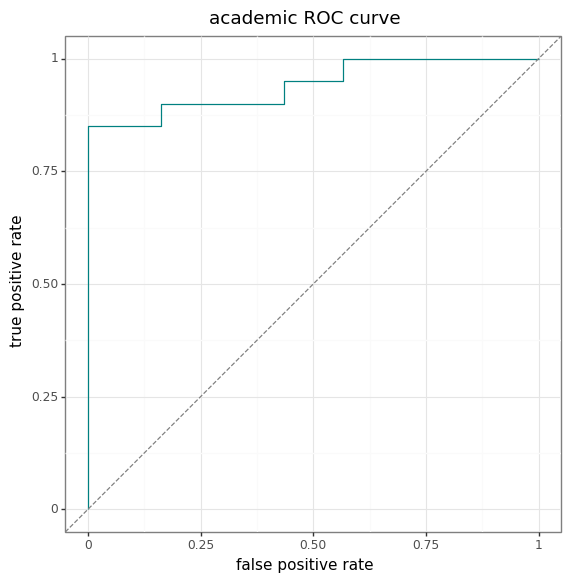

<ggplot: (8786014981845)>

In [ ]:
(ggplot(academic, aes(x='fpr', y='tpr'))
+ geom_line(color='teal')
+ geom_abline(intercept=0, slope=1, linetype='dashed', color='grey')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='false positive rate', y='true positive rate', title='academic ROC curve')
+ theme_bw())

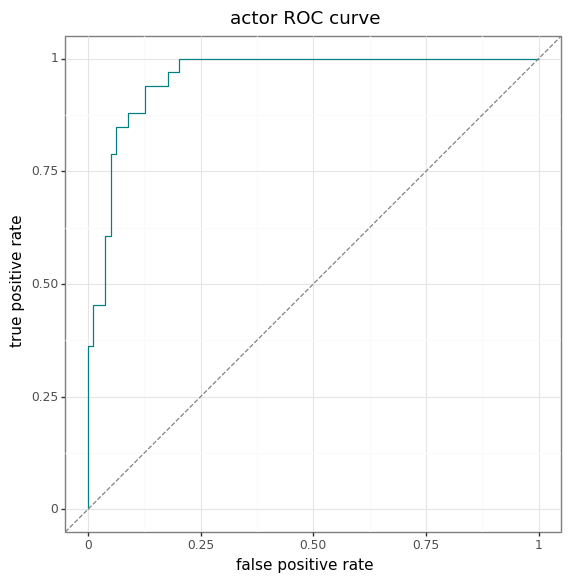

<ggplot: (8786014939793)>

In [ ]:
(ggplot(actor, aes(x='fpr', y='tpr'))
+ geom_line(color='teal')
+ geom_abline(intercept=0, slope=1, linetype='dashed', color='grey')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='false positive rate', y='true positive rate', title='actor ROC curve')
+ theme_bw())

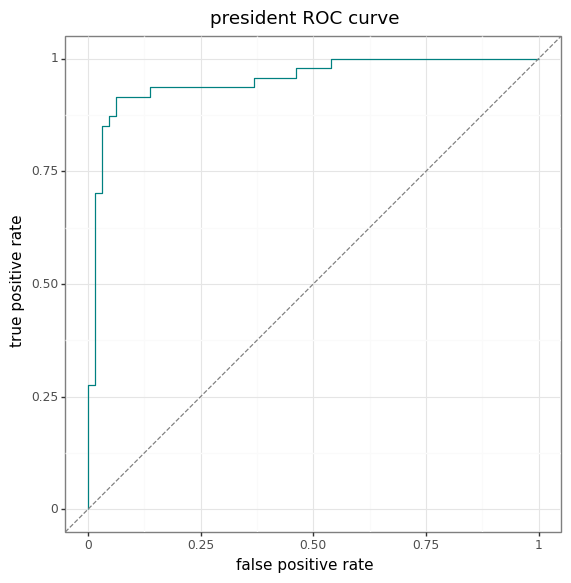

<ggplot: (8786014877753)>

In [ ]:
(ggplot(president, aes(x='fpr', y='tpr'))
+ geom_line(color='teal')
+ geom_abline(intercept=0, slope=1, linetype='dashed', color='grey')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='false positive rate', y='true positive rate', title='president ROC curve')
+ theme_bw())

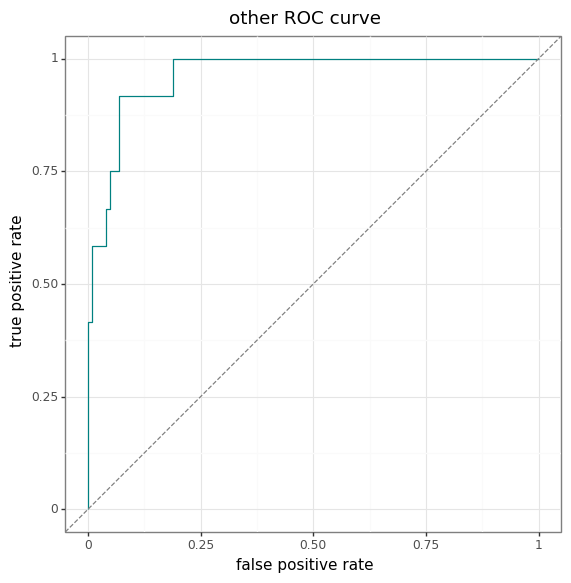

<ggplot: (8786017178237)>

In [ ]:
(ggplot(other, aes(x='fpr', y='tpr'))
+ geom_line(color='teal')
+ geom_abline(intercept=0, slope=1, linetype='dashed', color='grey')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='false positive rate', y='true positive rate', title='other ROC curve')
+ theme_bw())

In [ ]:
# calculate precision and recall for each category

prec_academic, recall_academic, thresholds_academic = precision_recall_curve(y_test, pred_df.academic, pos_label='academic')
academic = pd.DataFrame({'precision':prec_academic, 'recall':recall_academic})

prec_actor, recall_actor, thresholds_actor = precision_recall_curve(y_test, pred_df.actor, pos_label='actor')
actor = pd.DataFrame({'precision':prec_actor, 'recall':recall_actor})

prec_other, recall_other, thresholds_other = precision_recall_curve(y_test, pred_df.other, pos_label='other')
other = pd.DataFrame({'precision':prec_other, 'recall':recall_other})

prec_president, recall_president, thresholds_president = precision_recall_curve(y_test, pred_df.president, pos_label='president')
president = pd.DataFrame({'precision':prec_president, 'recall':recall_president})

other

,precision,recall
0,0.387097,1.000000
1,0.366667,0.916667
2,0.379310,0.916667
3,0.392857,0.916667
4,0.407407,0.916667
5,0.423077,0.916667
6,0.440000,0.916667
7,0.458333,0.916667
8,0.478261,0.916667
9,0.500000,0.916667


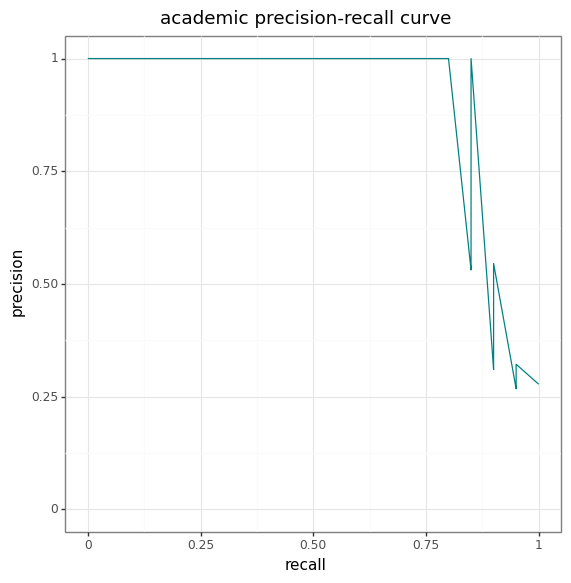

<ggplot: (8786014825837)>

In [ ]:
(ggplot(academic, aes(x='recall', y='precision'))
+ geom_line(color='teal')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='recall', y='precision', title='academic precision-recall curve')
+ theme_bw())

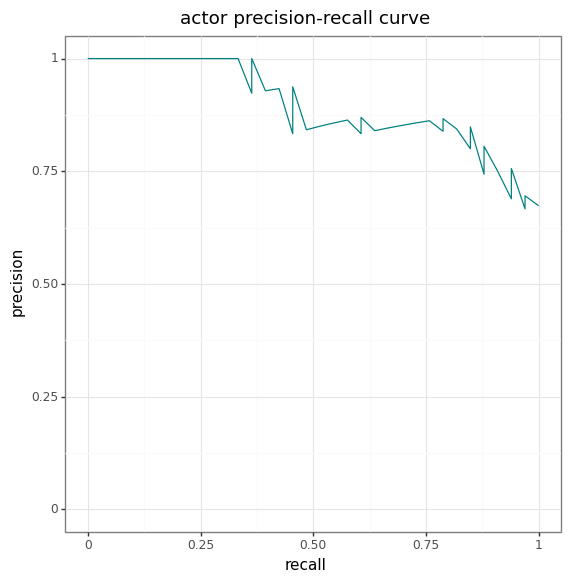

<ggplot: (8786014800985)>

In [ ]:
(ggplot(actor, aes(x='recall', y='precision'))
+ geom_line(color='teal')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='recall', y='precision', title='actor precision-recall curve')
+ theme_bw())

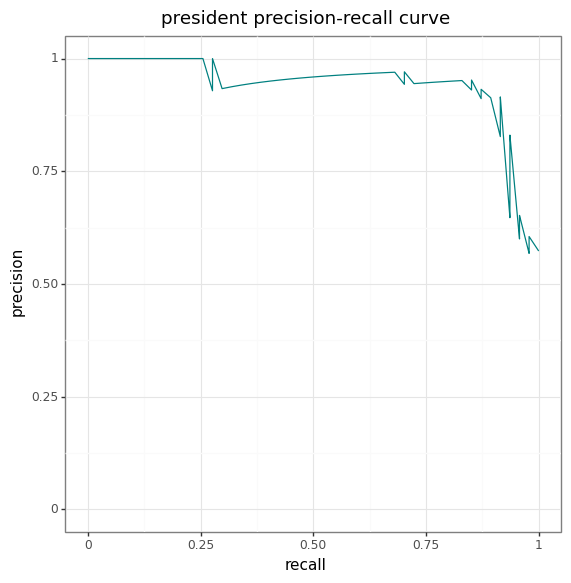

<ggplot: (8786014791993)>

In [ ]:
(ggplot(president, aes(x='recall', y='precision'))
+ geom_line(color='teal')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='recall', y='precision', title='president precision-recall curve')
+ theme_bw())

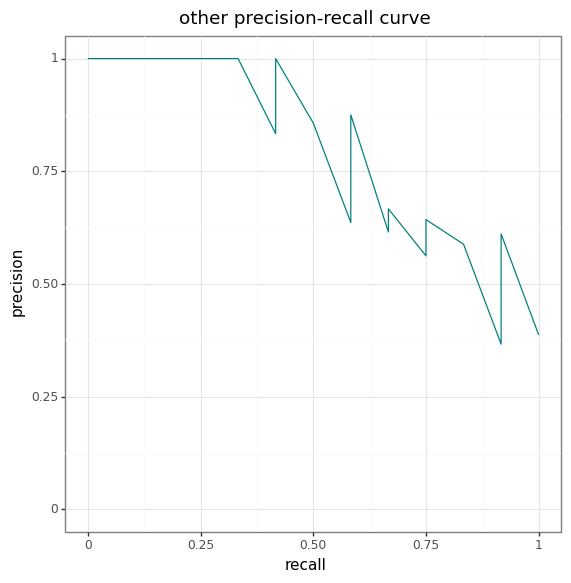

<ggplot: (8786015065417)>

In [ ]:
(ggplot(other, aes(x='recall', y='precision'))
+ geom_line(color='teal')
+ xlim(0, 1) + ylim(0, 1) + coord_fixed()
+ labs(x='recall', y='precision', title='other precision-recall curve')
+ theme_bw())

In [ ]:
# TODO: Plot a confusion matrix for your multiclass classifier for predictions
# on your validation set(s).
# Hint: Calculating the matrix by hand isn't difficult, but you are also welcome
# to take advantage of any convenient functions sklearn provides for evaluation metrics

categories = ['academic', 'actor', 'president', 'other']
rows = ['predicted academic', 'predicted actor', 'predicted president', 'predicted other']
academic = []
actor = []
president = []
other = []
cols = [academic, actor, president, other]

for i in range(len(categories)):
  actual = pred_df.loc[pred_df.actual == categories[i]]
  cols[i].append((actual.loc[actual.pred == 'academic']).shape[0])
  cols[i].append((actual.loc[actual.pred == 'actor']).shape[0])
  cols[i].append((actual.loc[actual.pred == 'president']).shape[0])
  cols[i].append((actual.loc[actual.pred == 'other']).shape[0])

cm = pd.DataFrame({'category':rows, 'actual academic':academic, 'actual actor':actor,
                   'actual president':president, 'actual other':other})
cm



,category,actual academic,actual actor,actual president,actual other
0,predicted academic,17,0,0,1
1,predicted actor,1,29,4,1
2,predicted president,1,4,43,3
3,predicted other,1,0,0,7


**Short Answer Question**: Looking at the confusion matrix, are there any categories that tend to get mixed up more than others? Does this make sense to you?

`[WRITE YOUR ANSWER HERE]`

The 'other' category tends to get mixed up the most relative to the amount of observation within each category. This makes sense since as we've seen from pca plot previously, the 'other' category has some over lap with other clusters and are more spread out. 'Other' category also makes sense logically since it comprises of multiple categories.

###Part 3: Text Classification II
Now, we test our classification skills by looking at data we have not yet touched (`test-bag_of_words.csv` and `test-tfidf.csv`).

Again, we will be using [Kaggle](https://www.kaggle.com/t/a06130cd74294709b2875e7cddae150b).

Unlike last time, for this homework, *you will be graded on your ability to pass perfomance benchmarks*. To receive full credit for this section of the assignment you will need to pass all three benchmarks (baseline, easy, and moderate) ***on both the public and private leaderboard***. Remember that since the private leaderboard is a part of your grade, you want to refrain from solely overfitting to the public leaderboard! Partial credit will be allotted depending on how many benchmarks are passed.

Passing the reach goal benchmark on the public or private leaderboard will receive 1 extra credit point (per leaderboard).


The top three leaders on the private leaderboard will recieve extra credit (if there are ties, everyone tied will receive the same number of points):
* 5 points for first place
* 3 points for second place
* 2 points for third place



The following Kaggle notes from the previous assignment still apply:
* You can use any team name (the name that will show up on the Kaggle leaderboard) as long as it is not inappropriate or offensive; however, in order to receive credit, you **must** specify your `team name` in your notebook here. If you do not, there is no way for us to assign you credit!
* Kaggle lists the close date as several days after the homework's due date. This is because Kaggle does not support late submissions. The homework and your submission on Kaggle are due by the due date listed here, but you may use late days and turn it in late (i.e., if you submit Kaggle predictions after the due date, it will automatically count towards your late days even if you have turned in your notebook already).
* This portion of the assignment **must** be completed independently. You cannot share prediction code or predictions with each other. In fact, you must put the exact code you use for your final predictions below. Violations will result in point deductions.
* Related, you cannot modify your prediction files manually. Violations will result in point deductions.
* You can only use classification models that we have discussed in class (though you can feel free to preprocess your data / tune any of the parameters in the models however you like)!



**Kaggle team name:** Pete Sirithanachai

Now, we will finally read in the test datasets.

In [ ]:
test_bag = pd.read_csv(DATADIR + "/test-bag_of_words.csv")
test_tfidf = pd.read_csv(DATADIR + "/test-tfidf.csv")

test_bag

,textid,0,000,1,10,11,12,13,14,15,...,written,wrong,wrote,x,yeah,year,yes,yet,york,young
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,729,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
177,732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,735,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
179,736,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# TODO: put all code needed (including preprocessing steps) to make your
# final kaggle submission; note that this code must match the predictions
# that you provide on kaggle

x_train = tfidf.drop(columns='textid')
y_train = doc_labels.category

x_test = test_tfidf.drop(columns='textid')

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

# train logistic regression
lr = LogisticRegression()
lr = lr.fit(x_train, y_train)
y_pred_kagg = lr.predict(x_test)

# k=4
# kmeans = KMeans(n_clusters=k, random_state=0)
# kmeans.fit(x_train)
# # pred = kmeans.predict(x_train)
# # pred_df = pd.DataFrame({'category':doc_labels.category, 'pred':pred})
# pred = kmeans.predict(x_test)
# # pred_df = pd.DataFrame({})
# # pred_df.groupby('pred').category.value_counts()

# # 0=president, 1=other, 2=academic, 3=actor
# y_pred_kagg = []
# for row in pred:
#   if row == 0:
#     y_pred_kagg.append('president')
#   elif row == 1:
#     y_pred_kagg.append('other')
#   elif row == 2:
#     y_pred_kagg.append('academic')
#   else:
#     y_pred_kagg.append('actor')

# # pred_df.apply(convert_to_cat, axis=1)
# len(y_pred_kagg)
# y_pred_kagg = np.array(y_pred_kagg)
# # accuracy_score(y_train, y_pred_kagg)

You can see details about the file format for submission on kaggle (`sample_submission.csv`, essentially a 2 column file with `textid`, the unique identifier in your test set, and `category`, your predictions). To make things easier, we provide here some sample code that you can modify to make your own submission file if your predictions were in a variable called `y_pred_kagg`.

In [ ]:
results = pd.Series(y_pred_kagg.flatten(), name="category")
results = pd.concat([test_bag['textid'], results], axis=1)
results.to_csv('my_submission.csv', index=False)

Once you output your csv file, you need to download the file from colab to your local computer (you can click the file folder icon on the left panel to see the files in your workspace) and upload that file to the Kaggle site as your submission. Note that you can submit multiple times (up to 10 times a day)!

### Part 4: Who said it? [Extra Credit: up to 10 points]

Looking only at our documents from presidents, can we figure out which presidents they are? To simplify this problem, we have gathered speeches for 20 different presidents and processed them (`presidents-bag_of_words.csv`, `presidents-tfidf.csv`, `presidents-labels.csv`). Four of these 20 presidents match the ones found in our earlier data.

Using your pick of methods (e.g., outlier detection, clustering, classification), can you guess which presidents are present in the original data? To answer this question, calculate a score or a probablity for each of the 20 presidents to the 4 anonymized presidents in our data.

This section is purely extra credit. Good faith attempts that result in predictions for any of the 20 presidents will automatically receive 2 points extra credit. Each correct prediction for the 4 presidents will receive 2 additional extra credit points (up to 8 points).

In [ ]:
# TODO: put all code needed for exploration here

**Short Answer Question (Extra Credit):** Which presidents do you think are in the training data?

`[WRITE YOUR ANSWER HERE]`

## To Submit
Download the notebook from Colab as a `.ipynb` notebook (`File > Download > Download .ipynb`) and upload it to the corresponding Gradescope assignment. Your assignment should be named `comp341-hw5.ipynb`.